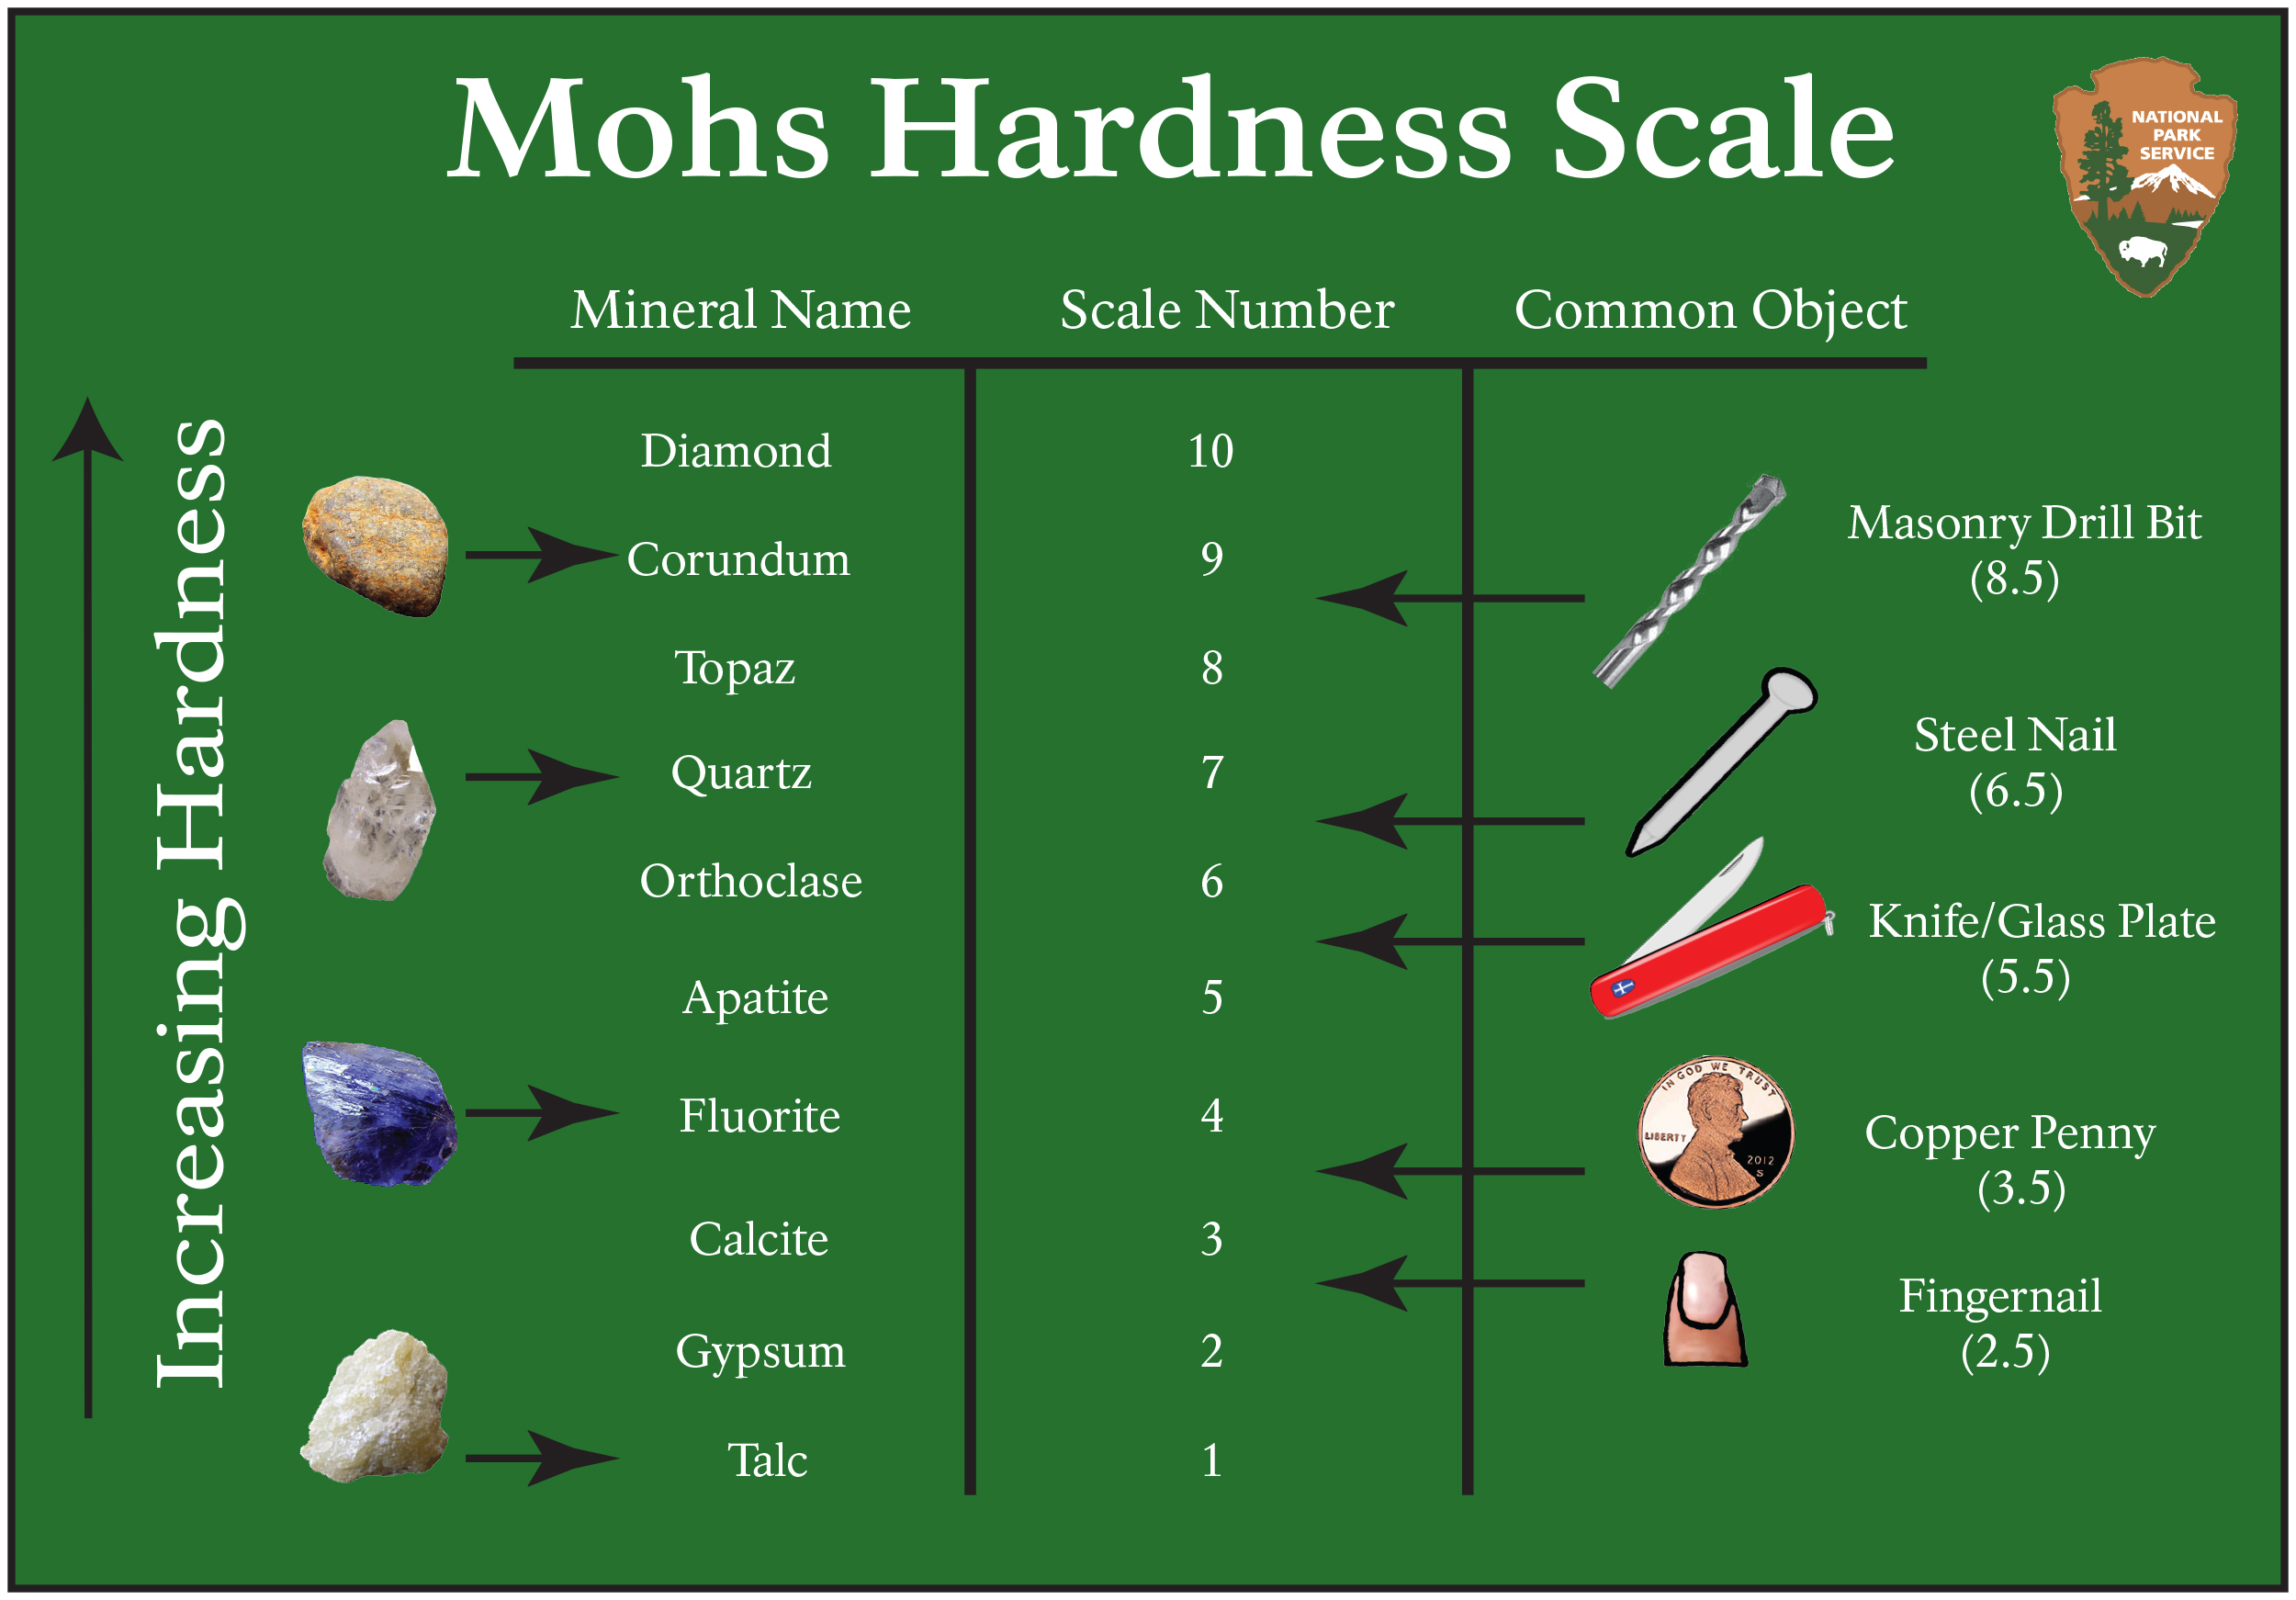


----

> Regression problem - Data Science competition - Practice

se construyó una base de datos de descriptores de características composicionales para entrenar modelos que predicen la dureza en una amplia variedad de minerales. Cada material fue representado por 11 descriptores atómicos, que incluyen el número de electrones, electrones de valencia, número atómico, electronegatividad, radios covalentes y de van der Waals, y energía de ionización.

El conjunto de datos describe un estudio sobre la predicción de la dureza en materiales naturales utilizando un enfoque de aprendizaje automático o estadístico. La dureza, que mide la resistencia de un material a la deformación permanente, es importante en el diseño de materiales como recubrimientos cerámicos y abrasivos. La prueba de dureza es útil por ser no destructiva y fácil de implementar. El estudio propone predecir la dureza integrando características atómicas y electrónicas a partir de la composición de minerales.

Para ello, se entrenaron clasificadores que permiten determinar si las características composicionales de los minerales pueden predecir su dureza según la escala de Mohs. Los datos se obtuvieron de fuentes como el CRC Handbook of Chemistry and Physics y la American Mineralogist Crystal Structure Database, con un total de 622 minerales de composiciones únicas. El conjunto de datos se compone de varios sistemas cristalinos (monoclínico, cúbico, hexagonal, etc.) y se validó con un conjunto independiente de cristales sintéticos.



# Setup 

In [91]:
# Importar librerías estándar
import numpy as np
import pandas as pd

# Importar librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Importar librerías científicas
from scipy import stats
from scipy.stats import norm, skew

# Importar librerías de Machine Learning
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Ignorar advertencias
import warnings
warnings.filterwarnings('ignore')

# Establecer opciones de visualización
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

# Configurar Seaborn y Matplotlib
sns.set_style('whitegrid')
plt.style.use('ggplot')

# Establecer configuraciones de Matplotlib
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

# Mostrar estilos disponibles por si deseas cambiar el estilo
print("Estilos disponibles en Matplotlib:")
print(plt.style.available)


Estilos disponibles en Matplotlib:
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


> NOTA:
El parámetro `axis` en la función `pd.concat()` de pandas determina cómo se concatenan los DataFrames:

- **`axis=0` (por defecto)**: concatena uno debajo del otro, es decir, por filas (se añaden filas nuevas).
- **`axis=1`**: concatena uno al lado del otro, es decir, por columnas (se añaden columnas nuevas).

En mi caso, al usar `axis=1`, estoy concatenando **`train`** y **`test`** **uno al lado del otro** (por columnas). Esto significa que las columnas del DataFrame `test` se añadirán a la derecha de las columnas del DataFrame `train`, manteniendo las mismas filas.




In [22]:
#Now let's import and put the train and test datasets in  pandas dataframe

def data_load():
    train = pd.read_csv('train.csv', index_col = 'id')
    test = pd.read_csv('test.csv', index_col = 'id')
    return train, test

train,test = data_load()

all_df = pd.concat([train,test], axis = 0)

original = pd.read_csv('Artificial_Crystals_Dataset.csv')
display(train)
display(test)
# display(original, original.shape)

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                              
0                 100.000          0.842                10.000          4.800   
1                 100.000          7.558                10.000          4.800   
2                  76.000          8.886                15.600          5.600   
3                 100.000          8.795                10.000          4.800   
4                 116.000          9.578                11.600          4.800   
...                   ...            ...                   ...            ...   
10402             128.000          7.558                12.000          4.000   
10403              30.000          1.743                10.000          5.333   
10404             196.000         30.920                24.500          5.500   
10405              38.000          1.553                12.667          4.667   
10406             288.000         24.655                11.143          4.571   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                   
0                    20.613             11.088               2.766   
1                    20.299             12.041               2.755   
2                    33.739             12.086               2.828   
3                    20.213             10.948               2.648   
4                    24.988             11.824               2.766   
...                     ...                ...                 ...   
10402                26.385             11.330               2.644   
10403                20.767             14.164               3.090   
10404                53.490             10.074               2.295   
10405                26.622             11.290               2.743   
10406                22.536             10.960               2.792   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                     
0                      1.732                  0.860            0.496   
1                      1.631                  0.910            0.493   
2                      1.788                  0.864            0.481   
3                      1.626                  0.936            0.489   
4                      1.682                  0.896            0.493   
...                      ...                    ...              ...   
10402                  1.631                  0.892            0.496   
10403                  1.557                  0.867            0.480   
10404                  1.545                  1.120            0.470   
10405                  1.757                  0.980            0.487   
10406                  1.773                  0.940            0.494   

       density_Average  Hardness  
id                                
0                0.915     6.000  
1                0.718     6.500  
2                1.506     2.500  
3                0.789     6.000  
4                1.865     6.000  
...                ...       ...  
10402            1.796     4.000  
10403            0.815     5.000  
10404            2.115     1.800  
10405            0.778     6.000  
10406            0.977     6.500  

[10407 rows x 12 columns]

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                              
10407             884.000        121.420                35.360          5.280   
10408              90.000          9.932                18.000          5.600   
10409             116.000          7.768                11.600          4.800   
10410             100.000          9.108                10.000          4.800   
10411              55.000          4.030                11.000          4.000   
...                   ...            ...                   ...            ...   
17341             446.000         36.135                 9.636          4.636   
17342              36.000          3.550                18.000          4.000   
17343              68.000          4.545                11.333          5.333   
17344              40.000          2.334                 6.667          4.000   
17345             134.000         17.590                67.000          5.000   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                   
10407                82.561              9.370               2.298   
10408                39.568             12.086               2.868   
10409                23.232             11.024               2.644   
10410                20.299             12.086               2.828   
10411                22.978             11.281               2.455   
...                     ...                ...                 ...   
17341                19.689             11.046               2.769   
17342                36.069              8.237               1.790   
17343                22.689             10.938               2.877   
17344                13.016             12.700               2.770   
17345               167.400              8.213               1.950   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                     
10407                  1.907                  1.200            0.462   
10408                  1.652                  0.864            0.476   
10409                  1.794                  0.960            0.500   
10410                  1.662                  0.792            0.496   
10411                  1.750                  0.893            0.476   
...                      ...                    ...              ...   
17341                  1.770                  0.872            0.499   
17342                  2.055                  1.390            0.499   
17343                  1.713                  0.917            0.499   
17344                  1.477                  0.617            0.664   
17345                  2.040                  1.410            0.402   

       density_Average  
id                      
10407            1.795  
10408            1.412  
10409            0.788  
10410            1.205  
10411            0.935  
...                ...  
17341            0.115  
17342            1.350  
17343            0.734  
17344            0.512  
17345            0.440  

[6939 rows x 11 columns]

# Data Basic Info.

In [8]:
from my import *

In [9]:
eda = my_EDA()
dirp(eda)


Object my_EDA created

['create_features', 'exploration_cat', 'exploration_num', 'get_missing_values', 'hypo_test', 'info', 'plot_high_corr_heatmap', 'plot_missing', 'plot_variable_distribution', 'scarplot_strongs_vars', 'unique_values', 'vars_list']


None

#### >>  infoo and  Describe() - estadistica descriptiva

con pandas.describe(), obtienes una visión general del comportamiento de los datos en esa columna: cuántos valores tiene, cuál es el promedio, qué tan dispersos están, y cuáles son los valores extremos (mínimos y máximos), además de los percentiles que nos ayudan a entender la distribución.

1. **`count`**: Nos dice cuántos valores no nulos hay en esa columna. Por ejemplo, si tienes 100 filas pero solo 90 valores no son nulos, el `count` será 90.

2. **`mean`**: Es el promedio o media aritmética de los valores en esa columna. Esto se calcula sumando todos los valores y dividiéndolos entre el número total de valores (los que no son nulos).

3. **`std`**: Es la desviación estándar, que nos indica qué tan dispersos están los datos con respecto a la media. Una desviación estándar alta significa que los valores están más alejados de la media, mientras que una baja indica que están más cerca.

4. **`min`**: Es el valor mínimo de la columna, el número más pequeño registrado.

5. **`25%`** (primer cuartil): Representa el valor por debajo del cual se encuentra el 25% de los datos. Es una medida de dispersión, donde el 25% de los valores son menores o iguales a este número.

6. **`50%`** (mediana o segundo cuartil): Es el valor que se encuentra justo en la mitad de los datos cuando están ordenados de menor a mayor. Es decir, el 50% de los valores son menores o iguales a este número.

7. **`75%`** (tercer cuartil): Representa el valor por debajo del cual se encuentra el 75% de los datos. El 75% de los valores son menores o iguales a este número.

8. **`max`**: Es el valor máximo de la columna, el número más grande registrado.


In [15]:
eda.info(train)

====> This data contains 10407 rows and 12 columns

FEATURE NAME  DATA FORMAT   NULL VALUES(NUM-PERC)          SEVEN SAMPLES  
------------  -----------   ---------------------          -------------  
allelectrons_Total float64        0 - nan %           80.0,138.0,236.18,126.0,150.0,38.0,122.0,
density_Total   float64        0 - nan %           11.351332,11.202328,8.903332,9.133,26.090000000000003,7.44274775,15.751995999999998,
allelectrons_Average float64        0 - nan %           12.8,10.0,11.3,19.0,9.5,10.4,49.0,
val_e_Average   float64        0 - nan %           4.7,4.666666666666667,2.6666666666666665,4.8,3.859070464767616,4.8,4.5,
atomicweight_Average float64        0 - nan %           111.599515,40.689515,37.346215,39.987666666666655,36.871575555555566,26.1647257,39.568056,
ionenergy_Average float64        0 - nan %           9.65936,12.04083,11.003309375,11.61422,11.68835,11.0881,11.64556,
el_neg_chi_Average float64        0 - nan %           2.9225000000000003,2.29,2.884,2.

c:\Users\Usuario\Desktop\fcp ML and DL proyects\fcp ML and DL proyects\Regression Problems\HARDNESS PRED playground-series-s3e25\my.py:114: RuntimeWarning: invalid value encountered in scalar divide
  str(round(100*missing_value/sum(self.missing_values),3))+' %'), end="")


count    mean     std   min    25%     50%     75%  \
allelectrons_Total    10407.000 128.054 224.124 0.000 68.000 100.000 131.000   
density_Total         10407.000  14.491  15.973 0.000  7.558  10.650  16.677   
allelectrons_Average  10407.000  17.033  10.469 0.000 10.000  12.600  22.000   
val_e_Average         10407.000   4.547   0.691 0.000  4.000   4.714   4.800   
atomicweight_Average  10407.000  37.508  26.012 0.000 20.299  26.204  48.719   
ionenergy_Average     10407.000  10.938   1.408 0.000 10.591  11.203  11.671   
el_neg_chi_Average    10407.000   2.608   0.335 0.000  2.530   2.706   2.805   
R_vdw_element_Average 10407.000   1.731   0.192 0.000  1.673   1.733   1.800   
R_cov_element_Average 10407.000   0.944   0.180 0.000  0.864   0.916   0.982   
zaratio_Average       10407.000   0.493   0.063 0.000  0.476   0.489   0.496   
density_Average       10407.000   2.133   1.937 0.000  0.815   1.352   2.742   
Hardness              10407.000   4.647   1.681 1.000  3.000   5.500   6.000   

                            max  
allelectrons_Total    15300.000  
density_Total           643.094  
allelectrons_Average     67.000  
val_e_Average             6.000  
atomicweight_Average    167.400  
ionenergy_Average        15.246  
el_neg_chi_Average        3.443  
R_vdw_element_Average     2.250  
R_cov_element_Average     1.616  
zaratio_Average           0.826  
density_Average          10.970  
Hardness                 10.000

* no tenemos en valores faltantes a imputar

----

* ahora buscamos duplicados: 

In [18]:
#Let's check duplicate rows in each dataset
print("Duplicate rows in Train dataset - ", all_df.duplicated().sum())
print("Duplicate rows in Test dataset - ", all_df.duplicated().sum())

Duplicate rows in Train dataset -  0
Duplicate rows in Test dataset -  0


# Análisis exploratorio de datos (EDA)

Este gráfico de distribuciones muestra las distribuciones de densidad (probabilidad) para varias características de los cangrejos del dataset. Los diferentes colores representan los percentiles y estadísticas clave de los datos:

- **Blue line (min)**: La línea azul marca el valor mínimo de la variable.
- **Yellow line (25%)**: Marca el primer cuartil (Q1), donde el 25% de los datos están por debajo de este valor.
- **Green line (median)**: La línea verde muestra la mediana, que es el valor central (Q2) cuando los datos están ordenados.
- **Orange line (mean)**: Representa la media (promedio) de la variable.
- **Red line (75%)**: Marca el tercer cuartil (Q3), donde el 75% de los datos están por debajo de este valor.
- **Dark red line (max)**: Marca el valor máximo de la variable.

In [19]:
#eda.exploration_num(train)

### Análisis Bivariado

In [20]:
numeric_columns = train.select_dtypes(include=['float64', 'int64'])
# eda.scarplot_strongs_vars(train,'Age', numeric_columns)

### Análisis Multivariado

#### Correlación: Mapa de calor

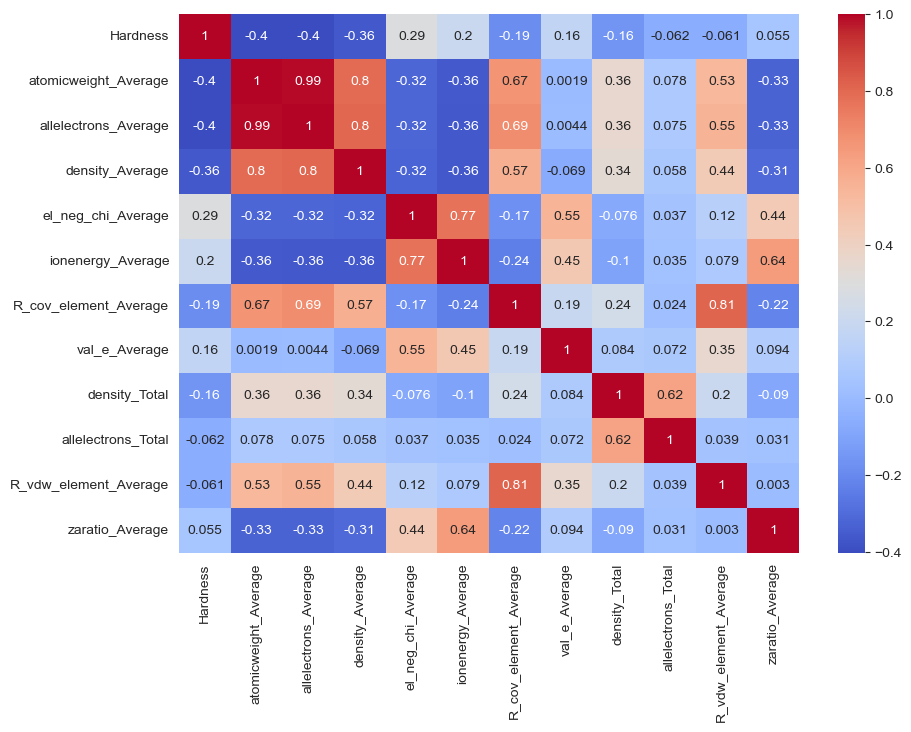

In [21]:
corr = eda.plot_high_corr_heatmap(train, 'Hardness')

In [25]:
# # Verifica la correlación
# corr_matrix = train.corr()

# # Identificar variables altamente correlacionadas
# threshold = 0.9  # Umbral de correlación
# high_corr = corr_matrix[(corr_matrix > threshold) & (corr_matrix != 1.0)]

# print(high_corr)  # Imprime las variables que tienen correlación alta

El mapa de calor representa la **matriz de correlación** entre diferentes variables, donde la variable objetivo es `Hardness`. La correlación mide la relación lineal entre dos variables, y va de -1 a 1:

- **1** significa una correlación positiva perfecta (cuando una sube, la otra también sube).
- **-1** significa una correlación negativa perfecta (cuando una sube, la otra baja).
- **0** significa que no hay correlación lineal.

### ¿Por qué se analiza una matriz de correlación?
La matriz de correlación es útil en modelos de aprendizaje automático supervisado porque te ayuda a:
   - **Identificar relaciones lineales**: Si algunas variables están muy correlacionadas con la variable objetivo, podrían ser buenos predictores.
   - **Detectar multicolinealidad**: Como se mencionó, las variables altamente correlacionadas entre sí (cercanas a 1 o -1) pueden afectar la estabilidad y la interpretación del modelo. Es importante reducir la multicolinealidad para obtener un modelo más robusto.

### Interpretación de este mapa de calor:

1. **Hardness (variable objetivo):**
   - `Hardness` tiene algunas correlaciones notables con otras variables, como una correlación positiva de **0.29** con `el_neg_chi_Average` y **0.2** con `ionenergy_Average`. Esto significa que estas variables tienen una leve relación positiva con la dureza, es decir, a medida que aumentan esos valores, la dureza también tiende a aumentar.
   - También hay correlaciones negativas con variables como `ato
   cweight_Average` (-0.4) y `allelectrons_Average` (-0.4), lo que indica que, a medida que aumentan esos valores, la dureza tiende a disminuir.

2. **Correlación fuerte entre variables predictoras:**
   - **`atomicweight_Average`** y **`allelectrons_Average`** tienen una correlación extremadamente alta (**0.99**). Esto indica que estas dos variables están casi perfectamente correlacionadas, lo que sugiere que contienen la misma información. 
   
   - **Problema de multicolinealidad:**
     Cuando tienes variables altamente correlacionadas (cercanas a 1 o -1), se genera un problema llamado **multicolinealidad**. Esto significa que el modelo no podrá distinguir fácilmente el efecto individual de cada una de estas variables. En este caso, podría ser recomendable eliminar una de las dos variables o combinarlas, ya que ambas aportan información muy similar. Mantener ambas puede afectar la interpretabilidad del modelo y hacer que los coeficientes de las variables no sean estables.
   
3. **Correlaciones bajas o cercanas a cero:**
   Variables que tienen una correlación cercana a cero (como `val_e_Average` con `Hardness`, con 0.16) no tienen una relación lineal fuerte con la variable objetivo. Sin embargo, esto no implica necesariamente que no tengan valor predictivo, ya que pueden tener relaciones no lineales con la variable objetivo.


-----
### Conclusion:

- Para predecir `Hardness`, las variables con correlaciones moderadas como `el_neg_chi_Average` o `ionenergy_Average` podrían ser útiles.
- La alta correlación entre `atomicweight_Average` y `allelectrons_Average` sugiere que debería eliminar una de ellas o combinarlas para evitar problemas de multicolinealidad. Esto permitirá reducir la multicolinealidad en el modelo y mejorar la interpretabilidad sin perder demasiada información.

### ¿Cuándo usar cada enfoque?
- **Eliminar variables** es útil cuando estás seguro de que las dos variables están altamente correlacionadas y no necesitas ambas.
- **Combinar variables** puede ser más útil cuando las dos variables representan diferentes aspectos de la misma información (como peso atómico y número de electrones) y quieres capturar ambas en una sola variable. 



In [43]:
# OPC. A 
def _combinar_variables(df):
    # Crear una nueva columna que sea el promedio de las dos variables
    df['atomic_electron_avg'] = (df['atomicweight_Average'] + df['allelectrons_Average']) / 2

    # Luego puedes eliminar las dos columnas originales si lo prefieres
    df_combined = df.drop(columns=['atomicweight_Average', 'allelectrons_Average'])

    display(df_combined.head())  # Muestra el DataFrame con la nueva variable
    return df_combined


# OPC. B
def _eliminar_electrons(df):
    df_droped = df.drop(columns=['allelectrons_Average'])
    return df_droped

all_df2 = all_df.copy()

all_df2_MODtest = _combinar_variables(all_df2)



allelectrons_Total  density_Total  val_e_Average  ionenergy_Average  \
id                                                                        
0              100.000          0.842          4.800             11.088   
1              100.000          7.558          4.800             12.041   
2               76.000          8.886          5.600             12.086   
3              100.000          8.795          4.800             10.948   
4              116.000          9.578          4.800             11.824   

    el_neg_chi_Average  R_vdw_element_Average  R_cov_element_Average  \
id                                                                     
0                2.766                  1.732                  0.860   
1                2.755                  1.631                  0.910   
2                2.828                  1.788                  0.864   
3                2.648                  1.626                  0.936   
4                2.766                  1.682                  0.896   

    zaratio_Average  density_Average  Hardness  atomic_electron_avg  
id                                                                   
0             0.496            0.915     6.000               15.306  
1             0.493            0.718     6.500               15.149  
2             0.481            1.506     2.500               24.670  
3             0.489            0.789     6.000               15.107  
4             0.493            1.865     6.000               18.294

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                              
0                 100.000          0.842                10.000          4.800   
1                 100.000          7.558                10.000          4.800   
2                  76.000          8.886                15.600          5.600   
3                 100.000          8.795                10.000          4.800   
4                 116.000          9.578                11.600          4.800   
...                   ...            ...                   ...            ...   
17341             446.000         36.135                 9.636          4.636   
17342              36.000          3.550                18.000          4.000   
17343              68.000          4.545                11.333          5.333   
17344              40.000          2.334                 6.667          4.000   
17345             134.000         17.590                67.000          5.000   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                   
0                    20.613             11.088               2.766   
1                    20.299             12.041               2.755   
2                    33.739             12.086               2.828   
3                    20.213             10.948               2.648   
4                    24.988             11.824               2.766   
...                     ...                ...                 ...   
17341                19.689             11.046               2.769   
17342                36.069              8.237               1.790   
17343                22.689             10.938               2.877   
17344                13.016             12.700               2.770   
17345               167.400              8.213               1.950   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                     
0                      1.732                  0.860            0.496   
1                      1.631                  0.910            0.493   
2                      1.788                  0.864            0.481   
3                      1.626                  0.936            0.489   
4                      1.682                  0.896            0.493   
...                      ...                    ...              ...   
17341                  1.770                  0.872            0.499   
17342                  2.055                  1.390            0.499   
17343                  1.713                  0.917            0.499   
17344                  1.477                  0.617            0.664   
17345                  2.040                  1.410            0.402   

       density_Average  Hardness  
id                                
0                0.915     6.000  
1                0.718     6.500  
2                1.506     2.500  
3                0.789     6.000  
4                1.865     6.000  
...                ...       ...  
17341            0.115       NaN  
17342            1.350       NaN  
17343            0.734       NaN  
17344            0.512       NaN  
17345            0.440       NaN  

[17346 rows x 12 columns]

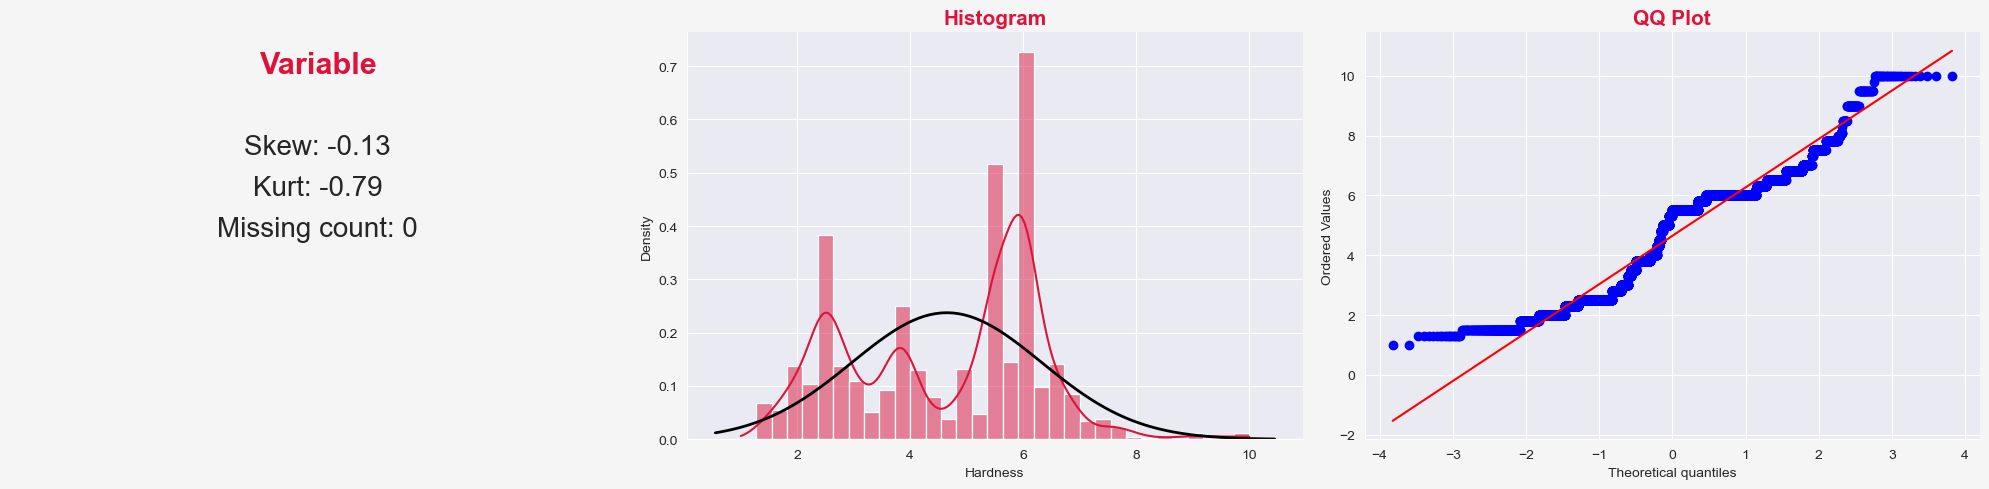

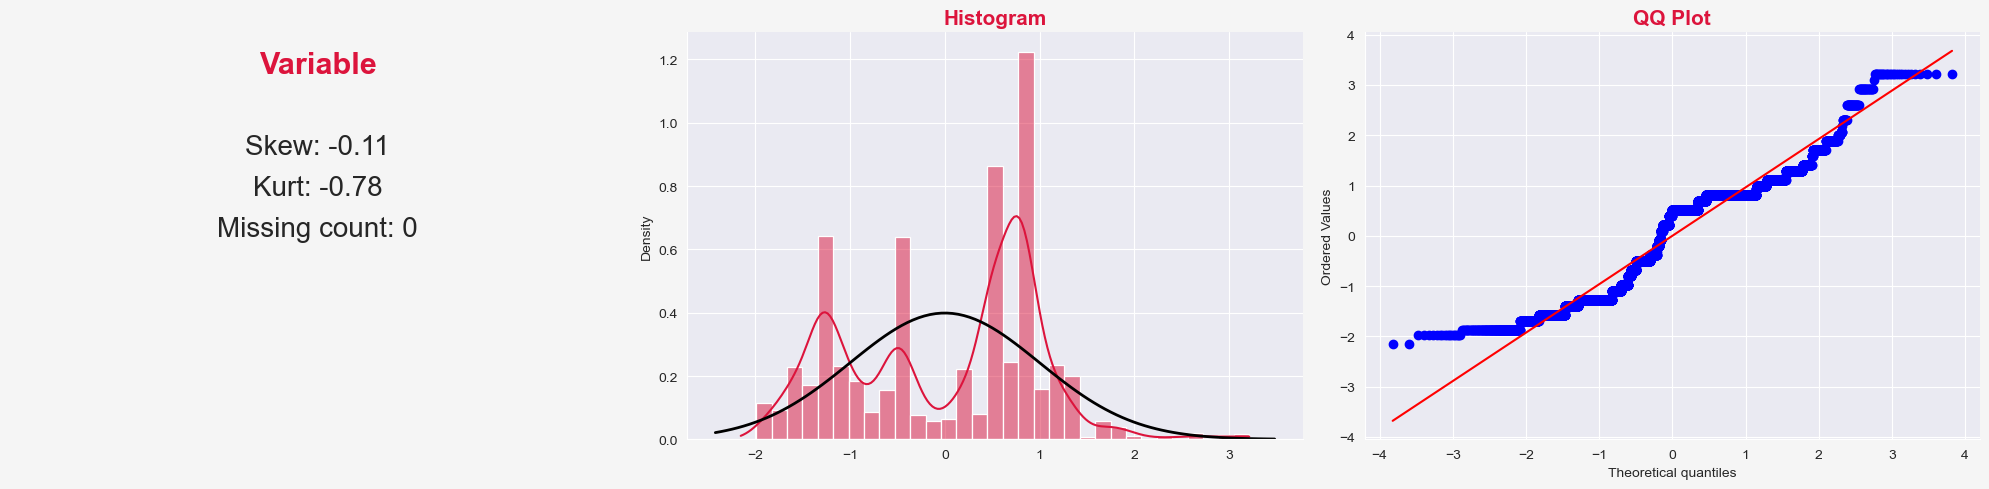

In [23]:
#concact both train & original datasets
y = train.pop("Hardness")
display(all_df)
eda.plot_variable_distribution(y)
eda.plot_variable_distribution(y,use_yeo_johnson=True)

### 1. **¿Qué es la distribución KDE (Kernel Density Estimation)?**
La **KDE (Kernel Density Estimation)** es una técnica que se utiliza para estimar la función de densidad de probabilidad de una variable continua. Básicamente, te proporciona una representación suave de la distribución de los datos (la línea negra en tus histogramas). A diferencia del histograma, que agrupa los datos en bins, la KDE no depende de la agrupación, sino que asigna una función continua a cada punto, lo que puede ayudarte a ver patrones más claramente.

- **¿Para qué sirve?**
  - **Visualización**: Te ayuda a identificar cómo están distribuidos los datos (sesgo, multimodalidad, etc.).
  - **Identificación de problemas**: Te permite observar posibles distribuciones no normales o picos en los datos que pueden afectar a la precisión de los modelos de regresión.

### 2. **QQ Plot**
El **QQ Plot (Quantile-Quantile Plot)** te muestra cómo se alinean tus datos reales con una distribución teórica (normal en este caso). Si los puntos se alinean con la línea roja, significa que tus datos siguen una distribución normal. En tu caso, parece haber desviaciones, especialmente en los extremos, lo que indica que la variable "Hardness" no sigue perfectamente una distribución normal.

### 3. **Transformación de datos con Yeo-Johnson**
El segundo gráfico corresponde a una transformación de Yeo-Johnson, que es una técnica que intenta hacer que los datos se asemejen más a una distribución normal. Se utiliza para estabilizar la varianza y hacer que los datos cumplan mejor con los supuestos de modelos como la regresión lineal, que asumen que los errores tienen una distribución normal.

- **Ventajas**: Si después de la transformación los datos se distribuyen mejor (más cercanos a la normalidad), los modelos de regresión lineal o aquellos que dependen de la normalidad pueden funcionar mejor.

### 4. **¿Qué hacer en este caso?**

Dado que "Hardness" tiene una distribución que no es normal, existen varias estrategias para mejorar el modelo de "regresión":

#### a. **Mantener la variable sin transformación**
Si se observa que la distribución de los datos originales no afecta gravemente el rendimiento de tu modelo, podría mantener la variable en su forma original y usar modelos que no dependen tanto de la normalidad, como los siguientes:
- **Regresión Lineal Regularizada (Ridge, Lasso)**: Aunque la regresión lineal puede verse afectada por la distribución, usar regularización puede mitigar esto. (NO EN ESTE CASO) 
- **Árboles de decisión, Random Forests, o Gradient Boosting**: Son modelos que no dependen de la normalidad de los datos. (SI, mas costosos computacionalmente, pero mas robustos) 


#### b. **Estrategia de ingeniería de características**
Si la variable "Hardness" tiene una relación compleja con las demás variables, podría generar nuevas características (features) para ayudar al modelo a capturar mejor las relaciones. Algunas técnicas incluyen:
- **Polinomios**: Generar términos de segundo o tercer grado (para capturar relaciones no lineales).
- **Interacciones entre variables**: Combinar variables correlacionadas para ver si capturan mejor la variación de "Hardness".


# Definimos "BaseLine".

o sea, una funcion para ir comparando cual de los pasos que damos es el "correcto".

### ¿Para que?
para la evaluacion de ingenería de atributos. Previo a la optimizacion de hyperparametros. 

### Métricas devueltas:
- **Mean Absolute Error (MAE)**: Representa el error promedio absoluto entre las predicciones y los valores reales.
- **Mean Squared Error (MSE)**: El promedio de los errores al cuadrado entre las predicciones y los valores reales.
- **Root Mean Squared Error (RMSE)**: La raíz cuadrada de MSE, una métrica comúnmente usada que tiene la misma escala que las variables originales.
- **R² Score**: El coeficiente de determinación, que mide qué tan bien las predicciones se ajustan a los valores reales (1 es un ajuste perfec datos.


---

Para hacer más útil la función `score_dataset` y mejorar la evaluación del rendimiento de un modelo de regresión, podría agregar gráficos visuales que permitan una mejor comprensión de los resultados, más allá de las métricas numéricas. Estos gráficos ayudarán a identificar patrones en los errores de predicción y otros aspectos importantes del rendimiento del modelo.


### 1. **Gráfico de dispersión (Scatter plot) de valores reales vs. predichos**
Este gráfico te permite visualizar cómo se alinean los valores predichos con los valores reales. Un buen modelo debería mostrar una relación lineal cerca de la línea \( y = x \).


### 2. **Gráfico de residuos (Residual Plot)**
El gráfico de residuos muestra la diferencia entre los valores reales y los valores predichos. Idealmente, los residuos deberían distribuirse aleatoriamente alrededor de cero, lo que indicaría que el modelo no tiene sesgo.


### 3. **Distribución de errores (Histograma de residuos)**
Un histograma de los residuos te permite ver si los errores del modelo están centrados alrededor de cero o si hay un sesgo en las predicciones.

### 4. **Gráfico Q-Q (Quantile-Quantile Plot)**
El gráfico Q-Q te ayuda a evaluar si los residuos siguen una distribución normal, lo cual es un supuesto en algunos modelos de regresión. Si los puntos siguen la línea diagonal, los errores se distribuyen normalmente.

### 5. **Curva de aprendizaje (Learning Curve)**
Este gráfico muestra cómo cambia la precisión del modelo a medida que aumenta el número de datos de entrenamiento. Es útil para detectar si el modelo está subentrenado o sobreentrenado.

### 6. **Importancia de características (Feature Importance)**
Si usas modelos como `XGBRegressor` o `RandomForestRegressor`, puedes visualizar la importancia de las características para ver cuáles están influyendo más en las predicciones.

----

Estos gráficos mejorarán nuestra capacidad para evaluar la calidad de un modelo de regresión más allá de solo métricas numéricas, permitiéndote detectar errores sistemáticos, problemas con los residuos y posibles mejoras en el rendimiento.

---

In [35]:
# GRAFICOS COMPLEMENTARIOS a la evalaucion de modelos previo a la ingeneniería de atributos

import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred):
    """ Gráfico de dispersión (Scatter plot) de valores reales vs. predichos: 
    Este gráfico te permite visualizar cómo se alinean los valores predichos con los valores reales. 
    Un buen modelo debería mostrar una relación lineal cerca de la línea    y = x"""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel("Valores reales")
    plt.ylabel("Valores predichos")
    plt.title("Valores reales vs. predichos")
    plt.show()

def plot_residuals(y_true, y_pred):
    """Gráfico de residuos (Residual Plot):
    El gráfico de residuos muestra la diferencia entre los valores reales y los valores predichos. Idealmente,
    los residuos deberían distribuirse aleatoriamente alrededor de cero, lo que indicaría que el modelo no tiene sesgo.
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Valores predichos")
    plt.ylabel("Residuos")
    plt.title("Gráfico de residuos")
    plt.show()


def plot_residual_histogram(y_true, y_pred):
    """Distribución de errores (Histograma de residuos):
    Un histograma de los residuos te permite ver si los errores del modelo están centrados alrededor de cero o si hay un sesgo en las predicciones.
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 6))
    plt.hist(residuals, bins=30, color='blue', alpha=0.7)
    plt.xlabel("Residuos")
    plt.ylabel("Frecuencia")
    plt.title("Histograma de residuos")
    plt.show()
    

import scipy.stats as stats
from sklearn.model_selection import learning_curve

def plot_qq(y_true, y_pred):
    """Gráfico Q-Q (Quantile-Quantile Plot):
    El gráfico Q-Q te ayuda a evaluar si los residuos siguen una distribución normal, lo cual es un supuesto en 
    algunos modelos de regresión. Si los puntos siguen la línea diagonal, los errores se distribuyen normalmente
    """
    residuals = y_true - y_pred
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q plot de los residuos")
    plt.show()


def plot_learning_curve(model, X, y, cv=5):
    """Curva de aprendizaje (Learning Curve):
    Este gráfico muestra cómo cambia la precisión del modelo a medida que aumenta el número de datos de entrenamiento. 
    Es útil para detectar si el modelo está subentrenado o sobreentrenado

    """
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, -train_scores_mean, 'o-', label="Training error")
    plt.plot(train_sizes, -test_scores_mean, 'o-', label="Validation error")
    plt.xlabel("Número de muestras de entrenamiento")
    plt.ylabel("Error")
    plt.title("Curva de aprendizaje")
    plt.legend(loc="best")
    plt.show()

# ******* 


In [33]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def encode_categorical(X, encoding_type="label"):
    """Encode categorical features based on encoding_type: 'label' or 'onehot'."""
    X_encoded = X.copy()
    
    if encoding_type == "label":
        # Label encoding for categorical columns
        for colname in X_encoded.select_dtypes(["category"]).columns:
            X_encoded[colname] = X_encoded[colname].cat.codes
    
    elif encoding_type == "onehot":
        # One-hot encoding for categorical columns
        X_encoded = pd.get_dummies(X_encoded, drop_first=True)
    
    return X_encoded

def score_dataset(X, y, model=XGBRegressor(), encoding_type="label", cv=5, plot=False):
    """
    Evaluate a dataset using cross-validation and return multiple evaluation metrics.
    
    Parameters:
    - X: Features (DataFrame)
    - y: Target (Series)
    - model: Machine learning model (default: XGBRegressor)
    - encoding_type: Type of encoding for categorical features ("label" or "onehot")
    - cv: Number of cross-validation folds (default: 5)
    
    Returns:
    A dictionary containing the following metrics:
    - Mean Absolute Error (MAE)
    - Mean Squared Error (MSE)
    - Root Mean Squared Error (RMSE)
    - R² Score
    """
    
    # Encode categorical features based on chosen encoding type
    X_encoded = encode_categorical(X, encoding_type=encoding_type)
    
    # Use cross_val_predict to get predictions across all cross-validation folds
    y_pred = cross_val_predict(model, X_encoded, y, cv=cv)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    # Return a dictionary with all metrics
    metrics = {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

    # Mostrar las métricas
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.4f}")
        
    # Gráficos
    if plot == True:
        plot_actual_vs_predicted(y, y_pred)
        plot_residuals(y, y_pred)
        plot_residual_histogram(y, y_pred)
        plot_qq(y, y_pred)
    
    return metrics



In [40]:
train,test = data_load()
y = train.pop("Hardness")
X = train

score_base = score_dataset(X, y) # model, predefinido es XGB

# es un 42% mejor que predecir con el promedio (segun la metrica r2)

Mean Absolute Error (MAE): 0.9357
Mean Squared Error (MSE): 1.6192
Root Mean Squared Error (RMSE): 1.2725
R² Score: 0.4266


Explicación de cada métrica con una interpretación de los resultados:

1. **Mean Absolute Error (MAE)**: 
   - **¿Qué es?**: La media de las diferencias absolutas entre los valores predichos y los valores reales. Mide el error promedio en unidades de la variable objetivo (en este caso, la dureza).
   - **¿Para qué sirve?**: Te indica, en promedio, cuánto se desvía el modelo de los valores reales.
   - **Interpretación del resultado (0.9357)**: En promedio, el modelo se equivoca en **0.9357 unidades** al predecir la dureza.

2. **Mean Squared Error (MSE)**:
   - **¿Qué es?**: El promedio de los errores al cuadrado entre los valores predichos y los reales. Penaliza errores más grandes más que el MAE.
   - **¿Para qué sirve?**: Da una idea del error general, pero pondera más fuertemente los errores grandes.
   - **Interpretación del resultado (1.6192)**: El modelo tiene un error medio al cuadrado de **1.6192**, lo que indica que algunos errores podrían ser más significativos.

3. **Root Mean Squared Error (RMSE)**:
   - **¿Qué es?**: La raíz cuadrada del MSE. Está en la misma escala que los valores de la variable objetivo, como el MAE, pero da más peso a los grandes errores.
   - **¿Para qué sirve?**: Te muestra el tamaño del error típico, penalizando más los errores grandes.
   - **Interpretación del resultado (1.2725)**: En promedio, el error típico en la predicción de dureza es de **1.2725 unidades**.

4. **R² Score (Coeficiente de Determinación)**:
   - **¿Qué es?**: Mide la proporción de la varianza en los datos que es explicada por el modelo. Va de 0 a 1, donde 1 es un ajuste perfecto y 0 significa que el modelo no mejora con respecto a predecir el promedio.
   - **¿Para qué sirve?**: Evalúa qué tan bien el modelo explica la variabilidad de los datos en comparación con el promedio. En términos simples, R² te dice cuán bien el modelo está capturando la esencia de los datos. Un valor más alto indica que el modelo es mejor para predecir, mientras que un valor más bajo sugiere que el modelo podría no estar aprovechando toda la información disponible

   > Comparando Líneas:
   * R² = 0: Si el modelo no explica nada de la variabilidad y su rendimiento es igual al promedio, entonces el R² sería 0. En este caso, no hay mejoría con respecto a predecir simplemente el promedio.
   * R² = 1: Si el modelo predice perfectamente cada punto (todos los puntos caen exactamente sobre la línea de predicción), entonces el R² sería 1. Esto significa que el modelo explica el 100% de la variabilidad de los datos.
   * R² entre 0 y 1: Un R² de 0.4266, por ejemplo, significa que el modelo explica aproximadamente el 42.66% de la variabilidad en la dureza. En otras palabras, hay un 57.34% de variabilidad que no está siendo explicada por el modelo, lo que sugiere que hay otros factores o características que podrían mejorar la predicción.
   - **Interpretación del resultado (0.4266)**: El modelo explica el **42.66%** de la variabilidad en los datos de dureza, lo que indica un rendimiento moderado.

   -------

   ### Conclusión Final

El modelo puede ser útil, pero se podrían considerar mejoras en la selección de características, la complejidad del modelo, o el uso de técnicas de ajuste adicionales para aumentar su capacidad predictiva. En resumen, aunque el modelo proporciona una base razonable para la predicción de dureza, es necesario realizar más ajustes y validaciones para optimizar su rendimiento. 

- **MAE** de **0.9357** sugiere que, en promedio, las predicciones se desvían menos de una unidad de la dureza real, lo que es aceptable en muchas aplicaciones prácticas. 
- **MSE** de **1.6192** y **RMSE** de **1.2725** indican que aunque hay errores, la mayoría no son extremadamente grandes, aunque algunos pueden ser significativos. 
- El **R² Score** de **0.4266** muestra que el modelo explica aproximadamente el **42.66%** de la variabilidad en los datos, lo que sugiere que hay espacio para mejorar. 


# Ingeniería de atributos

### -- 1) Eliminación o combinación de variables muy correlacionadas (atomicwheight_average y allelectrons_average)

In [49]:
train.head()

allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                           
0              100.000          0.842                10.000          4.800   
1              100.000          7.558                10.000          4.800   
2               76.000          8.886                15.600          5.600   
3              100.000          8.795                10.000          4.800   
4              116.000          9.578                11.600          4.800   

    atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                
0                 20.613             11.088               2.766   
1                 20.299             12.041               2.755   
2                 33.739             12.086               2.828   
3                 20.213             10.948               2.648   
4                 24.988             11.824               2.766   

    R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                  
0                   1.732                  0.860            0.496   
1                   1.631                  0.910            0.493   
2                   1.788                  0.864            0.481   
3                   1.626                  0.936            0.489   
4                   1.682                  0.896            0.493   

    density_Average  atomic_electron_avg  
id                                        
0             0.915               15.306  
1             0.718               15.149  
2             1.506               24.670  
3             0.789               15.107  
4             1.865               18.294

In [44]:
# ELIMINACION
train_mod1 = _combinar_variables(train)
train_mod2 = _eliminar_electrons(train)

allelectrons_Total  density_Total  val_e_Average  ionenergy_Average  \
id                                                                        
0              100.000          0.842          4.800             11.088   
1              100.000          7.558          4.800             12.041   
2               76.000          8.886          5.600             12.086   
3              100.000          8.795          4.800             10.948   
4              116.000          9.578          4.800             11.824   

    el_neg_chi_Average  R_vdw_element_Average  R_cov_element_Average  \
id                                                                     
0                2.766                  1.732                  0.860   
1                2.755                  1.631                  0.910   
2                2.828                  1.788                  0.864   
3                2.648                  1.626                  0.936   
4                2.766                  1.682                  0.896   

    zaratio_Average  density_Average  atomic_electron_avg  
id                                                         
0             0.496            0.915               15.306  
1             0.493            0.718               15.149  
2             0.481            1.506               24.670  
3             0.489            0.789               15.107  
4             0.493            1.865               18.294

In [46]:
# ****
score_base = score_dataset(train_mod1, y) # model, predefinido es XGB # VEMOS UNA LIGERA MEJRORIA en cuanto a "_combinar_varialbes" ambas variables muy correlacionadas (0.99) gracias a su "promedio" y luego eliminando las columans sobrantes
# ****

Mean Absolute Error (MAE): 0.9333
Mean Squared Error (MSE): 1.6152
Root Mean Squared Error (RMSE): 1.2709
R² Score: 0.4280


In [47]:
score_base = score_dataset(train_mod2, y) # model, predefinido es XGB

Mean Absolute Error (MAE): 0.9378
Mean Squared Error (MSE): 1.6260
Root Mean Squared Error (RMSE): 1.2751
R² Score: 0.4242


### -- 2) Crearé una nueva caracteristica personalizada y vere si mejora su rendimiento

In [64]:
import pandas as pd

# Función para calcular la suma y dividir por los cuadrados
def calculate_custom_metric(df):
    # Sumar las columnas especificadas
    suma = (df["val_e_Average"] +
            df["ionenergy_Average"] +
            df["el_neg_chi_Average"] +
            df["R_vdw_element_Average"] +
            df["R_cov_element_Average"] +
            df["zaratio_Average"] +
            df["density_Average"] +
            df["atomic_electron_avg"])

    # Calcular los cuadrados de allelectrons_Total y density_Total
    cuadrados = df["allelectrons_Total"]**3 + df["density_Total"]**3

    # Calcular la métrica final
    resultado = suma / cuadrados

    return resultado

_train_custom = train.copy()

# Ejemplo de uso
# Suponiendo que ya tienes un DataFrame df
_train_custom['custom_metric'] = calculate_custom_metric(_train_custom)

# Mostrar el DataFrame con la nueva columna
print(_train_custom[['custom_metric']])
display(_train_custom)


       custom_metric
id                  
0              0.000
1              0.000
2              0.000
3              0.000
4              0.000
...              ...
10402          0.000
10403          0.002
10404          0.000
10405          0.001
10406          0.000

[10407 rows x 1 columns]


allelectrons_Total  density_Total  allelectrons_Average  val_e_Average  \
id                                                                              
0                 100.000          0.842                10.000          4.800   
1                 100.000          7.558                10.000          4.800   
2                  76.000          8.886                15.600          5.600   
3                 100.000          8.795                10.000          4.800   
4                 116.000          9.578                11.600          4.800   
...                   ...            ...                   ...            ...   
10402             128.000          7.558                12.000          4.000   
10403              30.000          1.743                10.000          5.333   
10404             196.000         30.920                24.500          5.500   
10405              38.000          1.553                12.667          4.667   
10406             288.000         24.655                11.143          4.571   

       atomicweight_Average  ionenergy_Average  el_neg_chi_Average  \
id                                                                   
0                    20.613             11.088               2.766   
1                    20.299             12.041               2.755   
2                    33.739             12.086               2.828   
3                    20.213             10.948               2.648   
4                    24.988             11.824               2.766   
...                     ...                ...                 ...   
10402                26.385             11.330               2.644   
10403                20.767             14.164               3.090   
10404                53.490             10.074               2.295   
10405                26.622             11.290               2.743   
10406                22.536             10.960               2.792   

       R_vdw_element_Average  R_cov_element_Average  zaratio_Average  \
id                                                                     
0                      1.732                  0.860            0.496   
1                      1.631                  0.910            0.493   
2                      1.788                  0.864            0.481   
3                      1.626                  0.936            0.489   
4                      1.682                  0.896            0.493   
...                      ...                    ...              ...   
10402                  1.631                  0.892            0.496   
10403                  1.557                  0.867            0.480   
10404                  1.545                  1.120            0.470   
10405                  1.757                  0.980            0.487   
10406                  1.773                  0.940            0.494   

       density_Average  atomic_electron_avg  custom_metric  
id                                                          
0                0.915               15.306          0.000  
1                0.718               15.149          0.000  
2                1.506               24.670          0.000  
3                0.789               15.107          0.000  
4                1.865               18.294          0.000  
...                ...                  ...            ...  
10402            1.796               19.193          0.000  
10403            0.815               15.383          0.002  
10404            2.115               38.995          0.000  
10405            0.778               19.644          0.001  
10406            0.977               16.839          0.000  

[10407 rows x 13 columns]

In [65]:
_train_custom = _train_custom.dropna()
_train_custom = _train_custom[~_train_custom.isin([float('inf'), float('-inf')]).any(axis=1)]
_train_custom.fillna(_train_custom.median(), inplace=True)


In [66]:
print("X_encoded shape:", _train_custom.shape)
print("y shape:", y.shape)
# Asegúrate de que y tenga el mismo índice que _train_custom
_y = y.loc[_train_custom.index]
print("_y shape: ", _y.shape)

X_encoded shape: (10355, 13)
y shape: (10407,)
_y shape:  (10355,)


In [67]:
score_base = score_dataset(_train_custom, _y) # model, predefinido es XGB

Mean Absolute Error (MAE): 0.9367
Mean Squared Error (MSE): 1.6137
Root Mean Squared Error (RMSE): 1.2703
R² Score: 0.4236


* Conclusion: no vale la pena introducir esta caracteristica personalizada
* nos quedaremos con la primer opcion, que eliminaría nuestro problema de multicolinealidad

## Skewed features - Estudiando el "sesgo" de cada Caracteristicas

In [70]:
numeric_feats = all_df.dtypes[all_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)



Skew in numerical features: 



Skew
allelectrons_Total    37.740
density_Total         11.434
atomicweight_Average   1.805
allelectrons_Average   1.670
density_Average        1.638
Hardness              -0.126
R_cov_element_Average -0.520
zaratio_Average       -1.444
val_e_Average         -2.261
el_neg_chi_Average    -3.374
ionenergy_Average     -3.458
R_vdw_element_Average -4.636

In [80]:
train,test = data_load()
train_shape = train.shape[0]


target = "Hardness"
y = train.pop(target)

all_df = pd.concat([train,test], axis = 0)
all_df_mod1 = _combinar_variables(all_df)

allelectrons_Total  density_Total  val_e_Average  ionenergy_Average  \
id                                                                        
0              100.000          0.842          4.800             11.088   
1              100.000          7.558          4.800             12.041   
2               76.000          8.886          5.600             12.086   
3              100.000          8.795          4.800             10.948   
4              116.000          9.578          4.800             11.824   

    el_neg_chi_Average  R_vdw_element_Average  R_cov_element_Average  \
id                                                                     
0                2.766                  1.732                  0.860   
1                2.755                  1.631                  0.910   
2                2.828                  1.788                  0.864   
3                2.648                  1.626                  0.936   
4                2.766                  1.682                  0.896   

    zaratio_Average  density_Average  atomic_electron_avg  
id                                                         
0             0.496            0.915               15.306  
1             0.493            0.718               15.149  
2             0.481            1.506               24.670  
3             0.489            0.789               15.107  
4             0.493            1.865               18.294

In [82]:
def _skew_box_cox(all_df):
    
    numeric_feats = all_df.dtypes[all_df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = all_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\SESGO en variables numericas: \n")
    skewness = pd.DataFrame({'SESGO' :skewed_feats})
    
    skewness = skewness[abs(skewness) > 0.75]
    print("Estas son {} caracteristicas numericas sesgadas producto del Box Cox transform".format(skewness.shape[0]))

    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        #all_df[feat] += 1
        all_df[feat] = boxcox1p(all_df[feat], lam)
        
    train = all_df[:train_shape]
    test = all_df[train_shape:]
    
    return train, test

train_skew, test_skew = _skew_box_cox(all_df_mod1)

score = score_dataset(train_skew, y)

# EL rendimiento, bajo. DESCARTADO

\SESGO en variables numericas: 

Estas son 10 caracteristicas numericas sesgadas producto del Box Cox transform
Mean Absolute Error (MAE): 0.9353
Mean Squared Error (MSE): 1.6192
Root Mean Squared Error (RMSE): 1.2725
R² Score: 0.4266


## PCA

In [90]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

_,PCA_all_df_mod1,_ = apply_pca(all_df_mod1)

pca_train = PCA_all_df_mod1[:train_shape]
pca_test = PCA_all_df_mod1[train_shape:]

score = score_dataset(pca_train, y) 

#EMPEORO. DESCARTAMOS el PCA

Mean Absolute Error (MAE): 1.0360
Mean Squared Error (MSE): 1.8922
Root Mean Squared Error (RMSE): 1.3756
R² Score: 0.3299


#### Clustering

In [115]:
from sklearn.cluster import KMeans

def cluster_labels(df, features, n_clusters=20):
    # Esta función se encarga de agrupar los datos y asignar etiquetas de clúster a cada observación
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)  # Escalado
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)  # K-means
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)  # Asignar etiquetas de clúster
    return X_new

def cluster_distance(df, features, n_clusters=20):
    # Esta función calcula las distancias de cada punto a los centroides de los clústeres
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)  # Escalado
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)  # Distancias a los centroides
    # Crear DataFrame con las distancias
    X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
    return X_cd


# Definir las características a utilizar
features = [
    'val_e_Average',
    'ionenergy_Average',
    'el_neg_chi_Average',
    'density_Total',
    'R_vdw_element_Average'
] # Esto permitirá observar cómo se agrupan las entidades basadas en propiedades electrónicas y físicas

clusters = cluster_labels(all_df_mod1, features, n_clusters=20)

print(clusters.head())

   Cluster
0        9
1        7
2        7
3        7
4        7


In [116]:
all_df_mod2 = pd.concat([all_df_mod1, clusters], axis = 1)
all_df_mod2.head()

allelectrons_Total  density_Total  val_e_Average  ionenergy_Average  \
0               2.380          0.513          1.199              1.548   
1               2.380          1.390          1.199              1.581   
2               2.283          1.457          1.264              1.583   
3               2.380          1.452          1.199              1.543   
4               2.432          1.488          1.199              1.574   

   el_neg_chi_Average  R_vdw_element_Average  R_cov_element_Average  \
0               0.967                  0.777                  0.520   
1               0.965                  0.753                  0.539   
2               0.976                  0.789                  0.522   
3               0.949                  0.752                  0.549   
4               0.967                  0.765                  0.534   

   zaratio_Average  density_Average  atomic_electron_avg  Cluster  
0            0.357            0.541                1.678        9  
1            0.355            0.462                1.674        7  
2            0.349            0.722                1.866        7  
3            0.353            0.492                1.673        7  
4            0.355            0.806                1.749        7

In [117]:
train_clust = all_df_mod2[:train_shape]
test_clust = all_df_mod2[train_shape:]

In [118]:
score = score_dataset(train_clust, y) # con 5 clusters es aceptable
# con 10 clusters MEJORO, R² Score: 0.4284
# con 20 MEJORO AUN MAS. R² Score: 0.4296
# con 35 EMPEORO. R² Score: 0.4222

# CONCLUSION:
# NOS quedamos con el de "clusters = 20"

Mean Absolute Error (MAE): 0.9349
Mean Squared Error (MSE): 1.6109
Root Mean Squared Error (RMSE): 1.2692
R² Score: 0.4296


* esto indica que el modelo ahora está explicando mejor la variabilidad de los datos (0.4296 o un 42.96% mejor que con solo predecir en base a el promedio).

# En conclusion a las evaluaciones realizadas, nos quedaremos con las siguientes funciones para nuestra pipeline

*  1) La de combinación de caracteristicas, sacando promedio y eliminandolas a fin de evitar problemas de multicolineadlidad (vimos la mejora: r2 = 0.428)

* 2) La de clustering, que hicimos hace un momento. con Clusters = 20 (mejoro aun mas el r2 = 0.4296)

In [121]:
# POR LO TANTO PARA LA PIPELINE quedaría lo siguente

train,test = data_load()
train_shape = train.shape[0]


target = "Hardness"
y = train.pop(target)

all_df = pd.concat([train,test], axis = 0)
all_df_mod1 = _combinar_variables(all_df)

# Definir las características a utilizar
features = [
    'val_e_Average',
    'ionenergy_Average',
    'el_neg_chi_Average',
    'density_Total',
    'R_vdw_element_Average'
] # Esto permitirá observar cómo se agrupan las entidades basadas en propiedades electrónicas y físicas

clusters = cluster_labels(all_df_mod1, features, n_clusters=20)

all_df_mod2 = pd.concat([all_df_mod1, clusters], axis = 1)

train_clust = all_df_mod2[:train_shape]
test_clust = all_df_mod2[train_shape:]

score = score_dataset(train_clust, y)

allelectrons_Total  density_Total  val_e_Average  ionenergy_Average  \
id                                                                        
0              100.000          0.842          4.800             11.088   
1              100.000          7.558          4.800             12.041   
2               76.000          8.886          5.600             12.086   
3              100.000          8.795          4.800             10.948   
4              116.000          9.578          4.800             11.824   

    el_neg_chi_Average  R_vdw_element_Average  R_cov_element_Average  \
id                                                                     
0                2.766                  1.732                  0.860   
1                2.755                  1.631                  0.910   
2                2.828                  1.788                  0.864   
3                2.648                  1.626                  0.936   
4                2.766                  1.682                  0.896   

    zaratio_Average  density_Average  atomic_electron_avg  
id                                                         
0             0.496            0.915               15.306  
1             0.493            0.718               15.149  
2             0.481            1.506               24.670  
3             0.489            0.789               15.107  
4             0.493            1.865               18.294

Mean Absolute Error (MAE): 0.9363
Mean Squared Error (MSE): 1.6117
Root Mean Squared Error (RMSE): 1.2695
R² Score: 0.4293


# Modelling - Modelado

#### Defininimos otra estrategia de validacion cruzada  - (Define another cross validation strategy)

In [126]:
import optuna
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold, cross_val_score

# Función de validación (rmsle)
n_folds = 5
def rmsle_cv(X, y, model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean()

# Función objetivo para optimizar XGBoost
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 10),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
        'nthread': -1  # Usar todos los hilos de CPU
    }

    model_xgb = xgb.XGBRegressor(**params, random_state=7)
    score = rmsle_cv(train_clust, y, model_xgb)
    return score

# Función objetivo para optimizar LightGBM
def objective_lgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'num_leaves': trial.suggest_int('num_leaves', 5, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10),
        'min_split_gain': trial.suggest_loguniform('min_split_gain', 1e-8, 1.0),
        'n_jobs': -1  # Usar todos los núcleos de CPU
    }

    model_lgb = lgb.LGBMRegressor(**params, random_state=7)
    score = rmsle_cv(train_clust, y, model_lgb)
    return score

# Crear estudios para XGBoost y LightGBM
study_xgb = optuna.create_study(direction='minimize')
study_lgb = optuna.create_study(direction='minimize')

# Optimizar ambos modelos en paralelo
study_xgb.optimize(objective_xgb, n_trials=50)
study_lgb.optimize(objective_lgb, n_trials=50)

# Imprimir los mejores hiperparámetros
print("Best XGBoost parameters: ", study_xgb.best_params)
print("Best LightGBM parameters: ", study_lgb.best_params)


[I 2024-10-20 14:12:44,755] A new study created in memory with name: no-name-4ad0ba8a-9a6f-46c8-8fd7-eb47a50fd22e
[I 2024-10-20 14:12:44,758] A new study created in memory with name: no-name-e06d4fe1-8fc6-4881-a2b7-d857bfe0edb2
[I 2024-10-20 14:13:30,653] Trial 0 finished with value: 1.239681927878841 and parameters: {'n_estimators': 2822, 'max_depth': 5, 'learning_rate': 0.029108516240914935, 'subsample': 0.8531966484406892, 'colsample_bytree': 0.6597936061549812, 'gamma': 3.8152981887610176e-05, 'min_child_weight': 5.717970774475793e-07, 'reg_alpha': 5.741837130928339e-08, 'reg_lambda': 1.7464919598161644e-06}. Best is trial 0 with value: 1.239681927878841.
[I 2024-10-20 14:13:44,324] Trial 1 finished with value: 1.2441845366590272 and parameters: {'n_estimators': 1851, 'max_depth': 4, 'learning_rate': 0.18842487286437054, 'subsample': 0.996625026456854, 'colsample_bytree': 0.7256291031993849, 'gamma': 0.25456624850014614, 'min_child_weight': 0.002068598577042521, 'reg_alpha': 1.9408

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:48:26,487] Trial 0 finished with value: 1.2132365209060194 and parameters: {'n_estimators': 832, 'num_leaves': 42, 'learning_rate': 0.028146381388306437, 'subsample': 0.6760424080681392, 'colsample_bytree': 0.574738023157001, 'min_child_samples': 31, 'reg_alpha': 6.568697005743301, 'reg_lambda': 0.0008284297226302409, 'min_split_gain': 0.014141309951187148}. Best is trial 0 with value: 1.2132365209060194.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that 

[I 2024-10-20 14:48:43,705] Trial 1 finished with value: 1.2812271004422457 and parameters: {'n_estimators': 1066, 'num_leaves': 48, 'learning_rate': 0.14538193687826273, 'subsample': 0.8509951084929488, 'colsample_bytree': 0.8677573204535411, 'min_child_samples': 27, 'reg_alpha': 1.7666438209784698, 'reg_lambda': 7.421386478147226, 'min_split_gain': 0.0020975452938760204}. Best is trial 0 with value: 1.2132365209060194.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:48:50,437] Trial 2 finished with value: 1.211585503292899 and parameters: {'n_estimators': 958, 'num_leaves': 10, 'learning_rate': 0.028085586726702215, 'subsample': 0.662133421565842, 'colsample_bytree': 0.5885000785901413, 'min_child_samples': 50, 'reg_alpha': 0.004311252202195737, 'reg_lambda': 0.1105000486118304, 'min_split_gain': 0.18880020516720075}. Best is trial 2 with value: 1.211585503292899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235675 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:49:54,924] Trial 3 finished with value: 1.2352909286380656 and parameters: {'n_estimators': 2898, 'num_leaves': 44, 'learning_rate': 0.011778341673730805, 'subsample': 0.7001609043028361, 'colsample_bytree': 0.9364021234246456, 'min_child_samples': 47, 'reg_alpha': 0.6575502195531282, 'reg_lambda': 3.744897037256108e-06, 'min_split_gain': 0.005578455467366867}. Best is trial 2 with value: 1.211585503292899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:50:07,187] Trial 4 finished with value: 1.217114654414256 and parameters: {'n_estimators': 2749, 'num_leaves': 5, 'learning_rate': 0.019050786590822974, 'subsample': 0.5872918698899307, 'colsample_bytree': 0.5720255992717023, 'min_child_samples': 27, 'reg_alpha': 0.01858698416265745, 'reg_lambda': 1.2018310743676098e-08, 'min_split_gain': 0.0005612189562774144}. Best is trial 2 with value: 1.211585503292899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:50:26,203] Trial 5 finished with value: 1.2317552792398498 and parameters: {'n_estimators': 1093, 'num_leaves': 37, 'learning_rate': 0.04084142561390362, 'subsample': 0.838556116977289, 'colsample_bytree': 0.7324311715835525, 'min_child_samples': 22, 'reg_alpha': 1.6707994143649805, 'reg_lambda': 0.002205853312554215, 'min_split_gain': 6.0693439752372174e-05}. Best is trial 2 with value: 1.211585503292899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:50:51,566] Trial 6 finished with value: 1.2402991244291424 and parameters: {'n_estimators': 1582, 'num_leaves': 27, 'learning_rate': 0.05533600727017179, 'subsample': 0.6134295499573854, 'colsample_bytree': 0.5191219745559227, 'min_child_samples': 15, 'reg_alpha': 2.762609761161555e-05, 'reg_lambda': 0.0022563833093732903, 'min_split_gain': 0.008808796687649195}. Best is trial 2 with value: 1.211585503292899.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:51:06,365] Trial 7 finished with value: 1.2058500816887234 and parameters: {'n_estimators': 740, 'num_leaves': 43, 'learning_rate': 0.01923021892027921, 'subsample': 0.5242466238697274, 'colsample_bytree': 0.4810098961201872, 'min_child_samples': 37, 'reg_alpha': 1.55025702568421, 'reg_lambda': 0.00017004514120715623, 'min_split_gain': 0.020879449536409904}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:51:16,024] Trial 8 finished with value: 1.2511190428792855 and parameters: {'n_estimators': 508, 'num_leaves': 36, 'learning_rate': 0.11675349007167529, 'subsample': 0.8478652473796963, 'colsample_bytree': 0.6358105152304646, 'min_child_samples': 25, 'reg_alpha': 1.4460602296764053e-08, 'reg_lambda': 3.962784030445121e-07, 'min_split_gain': 2.2564574591275197e-07}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:51:36,637] Trial 9 finished with value: 1.2149960515134883 and parameters: {'n_estimators': 2779, 'num_leaves': 11, 'learning_rate': 0.018754450246082174, 'subsample': 0.915442261023994, 'colsample_bytree': 0.8044296895706036, 'min_child_samples': 44, 'reg_alpha': 2.547215509755562e-06, 'reg_lambda': 6.65656028704129e-08, 'min_split_gain': 1.256864428917842e-07}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:52:01,337] Trial 10 finished with value: 1.2475364159935267 and parameters: {'n_estimators': 2079, 'num_leaves': 25, 'learning_rate': 0.0780842499920922, 'subsample': 0.5095517339010213, 'colsample_bytree': 0.4520918823766268, 'min_child_samples': 5, 'reg_alpha': 0.009810365835080525, 'reg_lambda': 1.800992524894629e-05, 'min_split_gain': 6.103440481790743e-06}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

[I 2024-10-20 14:52:14,086] Trial 11 finished with value: 1.209726037458132 and parameters: {'n_estimators': 1541, 'num_leaves': 18, 'learning_rate': 0.010420881044384014, 'subsample': 0.5029307247357744, 'colsample_bytree': 0.40109407813626125, 'min_child_samples': 38, 'reg_alpha': 0.00691683674122151, 'reg_lambda': 0.36635295520050587, 'min_split_gain': 0.8706848601692596}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[

[I 2024-10-20 14:52:26,904] Trial 12 finished with value: 1.2088897420872429 and parameters: {'n_estimators': 1723, 'num_leaves': 20, 'learning_rate': 0.010724747400313534, 'subsample': 0.5063939087584262, 'colsample_bytree': 0.40832491494128564, 'min_child_samples': 39, 'reg_alpha': 0.05315991512444735, 'reg_lambda': 0.09588782755292817, 'min_split_gain': 0.9934165331705922}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because t

[I 2024-10-20 14:52:49,021] Trial 13 finished with value: 1.2068504337333628 and parameters: {'n_estimators': 2106, 'num_leaves': 22, 'learning_rate': 0.016068869621144097, 'subsample': 0.5854549323572098, 'colsample_bytree': 0.4729875803643564, 'min_child_samples': 37, 'reg_alpha': 0.07907545085612154, 'reg_lambda': 6.788224177724269e-05, 'min_split_gain': 0.14807986843523926}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split re

[I 2024-10-20 14:53:30,092] Trial 14 finished with value: 1.218804363065885 and parameters: {'n_estimators': 2239, 'num_leaves': 34, 'learning_rate': 0.01859798801051047, 'subsample': 0.5765927318302553, 'colsample_bytree': 0.4933240231867231, 'min_child_samples': 34, 'reg_alpha': 0.0002506804965541217, 'reg_lambda': 8.048199437441827e-05, 'min_split_gain': 0.05589523319850555}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:53:56,420] Trial 15 finished with value: 1.2281524280406992 and parameters: {'n_estimators': 2259, 'num_leaves': 20, 'learning_rate': 0.02999517400126393, 'subsample': 0.7649602600818812, 'colsample_bytree': 0.6737665001766162, 'min_child_samples': 40, 'reg_alpha': 0.1557832035381894, 'reg_lambda': 2.772198438988947e-06, 'min_split_gain': 9.086497640416152e-05}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:54:27,904] Trial 16 finished with value: 1.2195251378986494 and parameters: {'n_estimators': 1947, 'num_leaves': 32, 'learning_rate': 0.015462693893160117, 'subsample': 0.5765560933463328, 'colsample_bytree': 0.7390761322027539, 'min_child_samples': 34, 'reg_alpha': 0.0006718302148346631, 'reg_lambda': 0.0001294359811176116, 'min_split_gain': 0.07406023857590485}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:54:56,237] Trial 17 finished with value: 1.2468707447392766 and parameters: {'n_estimators': 1339, 'num_leaves': 49, 'learning_rate': 0.0410845814873683, 'subsample': 0.7429028698133254, 'colsample_bytree': 0.49948185330702277, 'min_child_samples': 43, 'reg_alpha': 0.20041815650151026, 'reg_lambda': 0.019332688952987367, 'min_split_gain': 1.0664288381285136e-05}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:55:45,659] Trial 18 finished with value: 1.2130309677388469 and parameters: {'n_estimators': 2489, 'num_leaves': 30, 'learning_rate': 0.015005876466890574, 'subsample': 0.9839654597246816, 'colsample_bytree': 0.6433986760891985, 'min_child_samples': 19, 'reg_alpha': 6.547411107171952, 'reg_lambda': 1.8703600903160378e-05, 'min_split_gain': 0.0008807096112817367}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 

[I 2024-10-20 14:56:04,010] Trial 19 finished with value: 1.2072714107756037 and parameters: {'n_estimators': 636, 'num_leaves': 41, 'learning_rate': 0.023931515243293806, 'subsample': 0.6485745426872552, 'colsample_bytree': 0.4694203006845154, 'min_child_samples': 33, 'reg_alpha': 0.0004987039570797188, 'reg_lambda': 0.00035257431180536395, 'min_split_gain': 0.021993377714440272}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:56:47,215] Trial 20 finished with value: 1.2690976177489641 and parameters: {'n_estimators': 2480, 'num_leaves': 24, 'learning_rate': 0.0580970662439179, 'subsample': 0.5410054720576543, 'colsample_bytree': 0.9948619591416491, 'min_child_samples': 16, 'reg_alpha': 1.4723789412455855e-07, 'reg_lambda': 0.00604568696052426, 'min_split_gain': 1.5612145666977107e-08}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:57:00,849] Trial 21 finished with value: 1.2067778807759728 and parameters: {'n_estimators': 642, 'num_leaves': 41, 'learning_rate': 0.023157505815090403, 'subsample': 0.631176797805627, 'colsample_bytree': 0.46370939249752074, 'min_child_samples': 32, 'reg_alpha': 0.00035600666962020365, 'reg_lambda': 0.00027374293953922387, 'min_split_gain': 0.041342524260485645}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furthe

[I 2024-10-20 14:57:19,788] Trial 22 finished with value: 1.207094286264307 and parameters: {'n_estimators': 1332, 'num_leaves': 40, 'learning_rate': 0.022852405581233602, 'subsample': 0.6141272229938314, 'colsample_bytree': 0.545621877783699, 'min_child_samples': 37, 'reg_alpha': 3.0275024247458324e-05, 'reg_lambda': 5.6296424618902245e-05, 'min_split_gain': 0.2003976191714383}. Best is trial 7 with value: 1.2058500816887234.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:57:39,779] Trial 23 finished with value: 1.204465167814362 and parameters: {'n_estimators': 742, 'num_leaves': 45, 'learning_rate': 0.015566267881147412, 'subsample': 0.5519939386726674, 'colsample_bytree': 0.4459215789914434, 'min_child_samples': 30, 'reg_alpha': 0.08121582060027777, 'reg_lambda': 2.697303157327295e-06, 'min_split_gain': 0.20649196044184653}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:57:58,770] Trial 24 finished with value: 1.2174630752526092 and parameters: {'n_estimators': 741, 'num_leaves': 44, 'learning_rate': 0.03595070680239271, 'subsample': 0.5431621321568812, 'colsample_bytree': 0.43394582935743164, 'min_child_samples': 30, 'reg_alpha': 0.002198948905798845, 'reg_lambda': 1.2753617495558568e-06, 'min_split_gain': 0.001964586962881994}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:58:15,960] Trial 25 finished with value: 1.2046892164124403 and parameters: {'n_estimators': 505, 'num_leaves': 50, 'learning_rate': 0.013119487636478307, 'subsample': 0.7107978854947642, 'colsample_bytree': 0.5207167738345467, 'min_child_samples': 24, 'reg_alpha': 9.001925959372109e-05, 'reg_lambda': 2.2570458461376478e-07, 'min_split_gain': 0.03006640033069979}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:58:37,487] Trial 26 finished with value: 1.207549231913757 and parameters: {'n_estimators': 898, 'num_leaves': 47, 'learning_rate': 0.01289918634997967, 'subsample': 0.7373910291349046, 'colsample_bytree': 0.6095262593435042, 'min_child_samples': 23, 'reg_alpha': 7.514690440432433e-06, 'reg_lambda': 2.2404792144601364e-07, 'min_split_gain': 0.00035668099550993323}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because t

[I 2024-10-20 14:58:56,514] Trial 27 finished with value: 1.2058040740533644 and parameters: {'n_estimators': 1227, 'num_leaves': 50, 'learning_rate': 0.013876239449637147, 'subsample': 0.551498339613396, 'colsample_bytree': 0.5355067140946688, 'min_child_samples': 11, 'reg_alpha': 7.544989899991112e-05, 'reg_lambda': 2.6607902070202714e-08, 'min_split_gain': 0.39126869798780967}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2024-10-20 14:59:15,688] Trial 28 finished with value: 1.206606834835516 and parameters: {'n_estimators': 1258, 'num_leaves': 50, 'learning_rate': 0.01338875929929802, 'subsample': 0.8003598499384326, 'colsample_bytree': 0.5360593392672308, 'min_child_samples': 8, 'reg_alpha': 5.940976658445043e-05, 'reg_lambda': 1.1830114117882638e-08, 'min_split_gain': 0.4812587326142403}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 14:59:29,357] Trial 29 finished with value: 1.2075680802099211 and parameters: {'n_estimators': 511, 'num_leaves': 46, 'learning_rate': 0.010143748781898006, 'subsample': 0.6746718862371539, 'colsample_bytree': 0.5581160419205878, 'min_child_samples': 11, 'reg_alpha': 1.5287394666848516e-06, 'reg_lambda': 6.337541758610536e-08, 'min_split_gain': 0.006797649662807545}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2024-10-20 14:59:42,210] Trial 30 finished with value: 1.2107755640312843 and parameters: {'n_estimators': 1082, 'num_leaves': 50, 'learning_rate': 0.031803308687455414, 'subsample': 0.7124792186680613, 'colsample_bytree': 0.6111603595475967, 'min_child_samples': 13, 'reg_alpha': 7.641517558643145e-05, 'reg_lambda': 5.1156137907013215e-08, 'min_split_gain': 0.29270978445726537}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:00:01,736] Trial 31 finished with value: 1.2073751805254833 and parameters: {'n_estimators': 801, 'num_leaves': 45, 'learning_rate': 0.013453410804511816, 'subsample': 0.5444096056840583, 'colsample_bytree': 0.5037399674919776, 'min_child_samples': 19, 'reg_alpha': 9.507716914047666, 'reg_lambda': 5.148896166626314e-07, 'min_split_gain': 0.019058997625389373}. Best is trial 23 with value: 1.204465167814362.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:00:17,153] Trial 32 finished with value: 1.203691916305126 and parameters: {'n_estimators': 715, 'num_leaves': 39, 'learning_rate': 0.01764474781916626, 'subsample': 0.549489697851674, 'colsample_bytree': 0.4301772311132719, 'min_child_samples': 28, 'reg_alpha': 0.5320279992386476, 'reg_lambda': 4.730823379420669e-06, 'min_split_gain': 0.08156394868283762}. Best is trial 32 with value: 1.203691916305126.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with pos

[I 2024-10-20 15:00:23,793] Trial 33 finished with value: 1.2470457563431618 and parameters: {'n_estimators': 943, 'num_leaves': 39, 'learning_rate': 0.19409988394758657, 'subsample': 0.5585304930026339, 'colsample_bytree': 0.4386610832844181, 'min_child_samples': 29, 'reg_alpha': 0.001946465408463063, 'reg_lambda': 6.504769952288504e-06, 'min_split_gain': 0.10833697060664524}. Best is trial 32 with value: 1.203691916305126.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-10-20 15:00:45,773] Trial 34 finished with value: 1.2036927863990174 and parameters: {'n_estimators': 1132, 'num_leaves': 47, 'learning_rate': 0.016072598353091157, 'subsample': 0.6362398305653872, 'colsample_bytree': 0.4272623871463913, 'min_child_samples': 25, 'reg_alpha': 0.344530400485335, 'reg_lambda': 1.4387842815801712e-07, 'min_split_gain': 0.3412606135859829}. Best is trial 32 with value: 1.203691916305126.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:01:14,071] Trial 35 finished with value: 1.2155469077704657 and parameters: {'n_estimators': 982, 'num_leaves': 47, 'learning_rate': 0.0258103582005302, 'subsample': 0.6823627310697555, 'colsample_bytree': 0.4020930079692869, 'min_child_samples': 26, 'reg_alpha': 0.6998028698813258, 'reg_lambda': 2.0602996721310802e-07, 'min_split_gain': 0.06104462179119636}. Best is trial 32 with value: 1.203691916305126.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:01:30,606] Trial 36 finished with value: 1.2027402972822085 and parameters: {'n_estimators': 675, 'num_leaves': 38, 'learning_rate': 0.017043086556388372, 'subsample': 0.6121948995446029, 'colsample_bytree': 0.4390939837142868, 'min_child_samples': 23, 'reg_alpha': 0.38338187251949674, 'reg_lambda': 1.0275138733058145e-05, 'min_split_gain': 0.0023851614878801987}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:01:45,522] Trial 37 finished with value: 1.2044779038629807 and parameters: {'n_estimators': 647, 'num_leaves': 38, 'learning_rate': 0.020584902964865832, 'subsample': 0.6181634126719433, 'colsample_bytree': 0.43414466138038027, 'min_child_samples': 21, 'reg_alpha': 0.027824495612231614, 'reg_lambda': 1.5189051943889927e-06, 'min_split_gain': 0.00325367666339137}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:02:11,351] Trial 38 finished with value: 1.2164223701850987 and parameters: {'n_estimators': 1142, 'num_leaves': 35, 'learning_rate': 0.0170409334136915, 'subsample': 0.5954719096264931, 'colsample_bytree': 0.8119503441364023, 'min_child_samples': 28, 'reg_alpha': 0.36236797361046713, 'reg_lambda': 1.6740422085399996e-05, 'min_split_gain': 0.0012705154012249706}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:02:29,838] Trial 39 finished with value: 1.216534224401825 and parameters: {'n_estimators': 823, 'num_leaves': 42, 'learning_rate': 0.03489523668612462, 'subsample': 0.6530645428307141, 'colsample_bytree': 0.5845670881434677, 'min_child_samples': 20, 'reg_alpha': 3.3254047331007195, 'reg_lambda': 7.337526814061292e-06, 'min_split_gain': 0.00032881018396151764}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 

[I 2024-10-20 15:02:50,480] Trial 40 finished with value: 1.2305948091846002 and parameters: {'n_estimators': 1009, 'num_leaves': 33, 'learning_rate': 0.049453617621797556, 'subsample': 0.6360134159155568, 'colsample_bytree': 0.44402460469195226, 'min_child_samples': 27, 'reg_alpha': 0.747724796677061, 'reg_lambda': 3.1582392320458326e-06, 'min_split_gain': 0.006957460811333526}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:03:05,983] Trial 41 finished with value: 1.2029284002742635 and parameters: {'n_estimators': 640, 'num_leaves': 38, 'learning_rate': 0.01823502367514817, 'subsample': 0.6091192189163878, 'colsample_bytree': 0.42246914970523664, 'min_child_samples': 21, 'reg_alpha': 0.037004977473848816, 'reg_lambda': 1.4060795361328568e-06, 'min_split_gain': 0.004197215082520544}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:03:21,463] Trial 42 finished with value: 1.2047202480792194 and parameters: {'n_estimators': 654, 'num_leaves': 37, 'learning_rate': 0.021034470203325557, 'subsample': 0.6035435574484238, 'colsample_bytree': 0.4232828558731836, 'min_child_samples': 17, 'reg_alpha': 0.02628364710056093, 'reg_lambda': 8.523588692404715e-07, 'min_split_gain': 0.013089696542832296}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:03:56,016] Trial 43 finished with value: 1.205669671480846 and parameters: {'n_estimators': 908, 'num_leaves': 43, 'learning_rate': 0.017105099243133366, 'subsample': 0.5672317076423791, 'colsample_bytree': 0.4652782428851949, 'min_child_samples': 24, 'reg_alpha': 0.08643098143496737, 'reg_lambda': 8.500658559856874e-06, 'min_split_gain': 3.7432945545102526e-05}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 

[I 2024-10-20 15:04:13,081] Trial 44 finished with value: 1.20635792693813 and parameters: {'n_estimators': 758, 'num_leaves': 28, 'learning_rate': 0.02752482548391298, 'subsample': 0.5334134502552978, 'colsample_bytree': 0.4911642689075317, 'min_child_samples': 30, 'reg_alpha': 1.5841426814483537, 'reg_lambda': 1.3624632863984833e-07, 'min_split_gain': 0.00021439982999849633}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:04:36,010] Trial 45 finished with value: 1.2054977285265869 and parameters: {'n_estimators': 874, 'num_leaves': 45, 'learning_rate': 0.018322566334773385, 'subsample': 0.6903505685188148, 'colsample_bytree': 0.4208054499288719, 'min_child_samples': 26, 'reg_alpha': 0.29592415331895205, 'reg_lambda': 5.238899649008341, 'min_split_gain': 0.003388024689895888}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements


[I 2024-10-20 15:05:05,650] Trial 46 finished with value: 1.2105176546804663 and parameters: {'n_estimators': 1424, 'num_leaves': 31, 'learning_rate': 0.011501541202480115, 'subsample': 0.5213090611965843, 'colsample_bytree': 0.9000157411157599, 'min_child_samples': 22, 'reg_alpha': 2.642820776649637, 'reg_lambda': 2.877517899179716e-05, 'min_split_gain': 0.2047432193310388}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[I 2024-10-20 15:05:10,076] Trial 47 finished with value: 1.2090964898499454 and parameters: {'n_estimators': 1132, 'num_leaves': 36, 'learning_rate': 0.08618817196820333, 'subsample': 0.6615161890743182, 'colsample_bytree': 0.4028064539522854, 'min_child_samples': 31, 'reg_alpha': 0.008200191595484817, 'reg_lambda': 7.671723057493027e-07, 'min_split_gain': 0.6932621842235056}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:05:24,336] Trial 48 finished with value: 1.205664862802994 and parameters: {'n_estimators': 565, 'num_leaves': 38, 'learning_rate': 0.01217912261806997, 'subsample': 0.5973515679078513, 'colsample_bytree': 0.4545366899956264, 'min_child_samples': 28, 'reg_alpha': 0.04439192789937881, 'reg_lambda': 2.339026455883888e-06, 'min_split_gain': 0.12397286007295842}. Best is trial 36 with value: 1.2027402972822085.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

[I 2024-10-20 15:05:34,618] Trial 49 finished with value: 1.2140826852557882 and parameters: {'n_estimators': 735, 'num_leaves': 15, 'learning_rate': 0.014896342665490647, 'subsample': 0.6292056032571908, 'colsample_bytree': 0.5162938118764757, 'min_child_samples': 17, 'reg_alpha': 0.5918739135258422, 'reg_lambda': 5.648054563542994e-06, 'min_split_gain': 0.012499944133473453}. Best is trial 36 with value: 1.2027402972822085.


Best XGBoost parameters:  {'n_estimators': 1226, 'max_depth': 7, 'learning_rate': 0.010352870959515918, 'subsample': 0.7879506988756171, 'colsample_bytree': 0.4032754201695782, 'gamma': 1.2479885391689032e-07, 'min_child_weight': 6.583484859061054e-06, 'reg_alpha': 0.2918127657796557, 'reg_lambda': 0.000472139323739338}
Best LightGBM parameters:  {'n_estimators': 675, 'num_leaves': 38, 'learning_rate': 0.017043086556388372, 'subsample': 0.6121948995446029, 'colsample_bytree': 0.4390939837142868, 'min_child_samples': 23, 'reg_alpha': 0.38338187251949674, 'reg_lambda': 1.0275138733058145e-05, 'min_split_gain': 0.0023851614878801987}


##### 1. Guardar los modelos entrenados
Después de optimizar y obtener los mejores hiperparámetros, se entrena los modelos finales con esos parámetros y se guárdan:

In [127]:
import joblib

# Entrenar modelo final de XGBoost con los mejores parámetros
best_xgb = xgb.XGBRegressor(**study_xgb.best_params, random_state=7)
best_xgb.fit(train_clust, y)

# Guardar el modelo XGBoost
joblib.dump(best_xgb, 'best_xgb_model.pkl')

# Entrenar modelo final de LightGBM con los mejores parámetros
best_lgb = lgb.LGBMRegressor(**study_lgb.best_params, random_state=7)
best_lgb.fit(train_clust, y)

# Guardar el modelo LightGBM
joblib.dump(best_lgb, 'best_lgb_model.pkl')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 10407, number of used features: 11
[LightGBM] [Info] Start training from score 4.647126


['best_lgb_model.pkl']

#### 2. Cargar los modelos guardados
Cuando se necesite usar los modelos en el futuro ... 

In [ ]:
# # Cargar el modelo XGBoost
# best_xgb_loaded = joblib.load('best_xgb_model.pkl')

# # Cargar el modelo LightGBM
# best_lgb_loaded = joblib.load('best_lgb_model.pkl')


### Base models: 

# Stacking models

Simplest Stacking approach : Averaging base models¶
We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse

In [128]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [130]:
# stacked_averaged_models = StackingAveragedModels(base_models = (best_xgb, best_lgb),
#                                                  meta_model = best_xgb)

# score = rmsle_cv(train_clust, y, stacked_averaged_models)
# print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2265
[LightGBM] [Info] Number of data points in the train set: 6660, number of used features: 11
[LightGBM] [Info] Start training from score 4.652245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2257
[LightGBM] [Info] Number of data points in the train set: 6661, number of used features: 11
[LightGBM] [Info] Start training from score 4.656741
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2268
[LightGBM] [Info] Number of data points in the train set: 6661, number of used features: 11
[LightGBM] [Info] Start traini

## AVERAGE

In [132]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    
averaged_models = AveragingModels(models = (best_xgb, best_lgb))

score = rmsle_cv(train_clust, y,averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2277
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.641512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 8325, number of used features: 11
[LightGBM] [Info] Start training from score 4.644101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 8326, number of used features: 11
[LightGBM] [Info] Start traini

In [133]:
# averaged_models # GUARDAMOS EL MODELO

# Guardar el modelo XGBoost
joblib.dump(averaged_models, 'averaged_models.pkl')

['averaged_models.pkl']

In [137]:
best_xgb.fit(train_clust, y)
xgb_pred = best_xgb.predict(test_clust)

best_lgb.fit(train_clust, y)
lgb_pred = best_lgb.predict(test_clust)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 10407, number of used features: 11
[LightGBM] [Info] Start training from score 4.647126


In [138]:
ensemble = xgb_pred*0.5 + lgb_pred*0.5

In [139]:
output = pd.DataFrame({'id': test.index, 'Hardness': ensemble})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
